# TOKENIZE

In [ ]:
import transformers
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [ ]:
def data_preprocessing(data, tokenizer, max_length):
  """Prepare the data for training. Return tokens with dim=1024."""

  # add special tokens
  # add sep token between text and summary
  special_tokens = {'pad_token':'<|pad|>','sep_token':'<|sep|>','eos_token':'<|endoftext|>'}
  num_add_toks = tokenizer.add_special_tokens(special_tokens)

  # start tokenizing
  summary = data['summary']
  text = data['text']
  tokens = []

  for i in range(len(data)):
    token_summary = tokenizer.batch_encode_plus([summary.iloc[i]], return_tensors='pt')['input_ids']
    token_text_len = max_length - token_summary.shape[1] - 2

    # check if the input size is already exceeded
    if token_text_len < 0:
      continue
    
    # make input size of 1024 without truncating summary (i.e. texts are truncated)
    token_text = tokenizer.batch_encode_plus([text.iloc[i]], return_tensors='pt')['input_ids']
    token_text = token_text[:, :token_text_len]
    token = torch.cat((token_text, torch.tensor([tokenizer.sep_token_id]).reshape(1,-1), token_summary, torch.tensor([tokenizer.eos_token_id]).reshape(1,-1)), 1)
    
    # check if len(text+<sep>+summary+<eos>) is smaller than max_length, if so, add pad_token
    while token.shape[1] < max_length:
      token = torch.cat((token, torch.tensor([tokenizer.pad_token_id]).reshape(1,-1)), 1)

    # add each token to a list
    tokens.append(token)

  return tokens

In [ ]:
max_length = 1024
tokens = data_preprocessing(train, tokenizer, max_length)

Token indices sequence length is longer than the specified maximum sequence length for this model (1333 > 1024). Running this sequence through the model will result in indexing errors


In [ ]:
tokens = torch.stack(tokens).reshape(-1,max_length)

In [ ]:
tokens.size()

torch.Size([4500, 1024])

# TRAINING

In [ ]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

In [ ]:
# hyperparameters
lr=1e-05
eps=1e-08
batch_size= 2
epochs= 5
dataset= tokens
tokenizer = tokenizer

# load pre-trained gpt-2 model
from transformers import GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained('gpt2',pad_token_id=tokenizer.eos_token_id)
model.resize_token_embeddings(len(tokenizer))
model= model.to(device)

In [ ]:
def train(dataset, lr, eps, batch_size, epochs, model, tokenizer, device):
  """ Train GPT2 model and print out training details."""
  
  model.train()

  train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
  optimizer =  torch.optim.Adam(model.parameters(),lr=lr,eps=eps) 
  loss_list = []

  for epoch in range(epochs):
    sum_loss = 0
    i = 0
    for id, input in enumerate(train_dataloader):
      input = input.to(device)
      optimizer.zero_grad()
      outputs = model(input, labels=input)

      loss = outputs.loss
      sum_loss += loss
      loss.backward()
      optimizer.step()

    print("epoch: {}/{} --> training loss: {}".format(epoch+1, epochs, sum_loss/dataset.shape[0]))
    loss_list.append(sum_loss/dataset.shape[0])

  return loss_list

In [ ]:
loss_list = train(dataset, lr, eps, batch_size, epochs, model, tokenizer, device)

epoch: 1/5 --> training loss: 1.8058485984802246
epoch: 2/5 --> training loss: 1.452378749847412
epoch: 3/5 --> training loss: 1.3925782442092896
epoch: 4/5 --> training loss: 1.3539971113204956
epoch: 5/5 --> training loss: 1.3253605365753174


In [ ]:
# save the model
model.save_pretrained('/..')

In [ ]:
def training_loss(loss_list, epochs):
  """ Draw training loss for different epochs """
  
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.title('Training Loss--GPT-2')
  plt.plot(range(1, epochs+1), loss_list, marker='o')
  plt.show

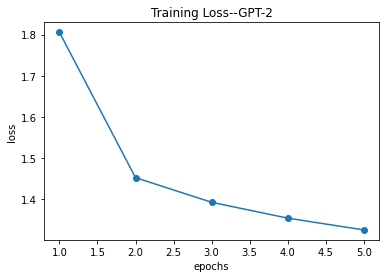

In [ ]:
training_loss(loss_list, epochs=epochs)

# GENERATE

In [ ]:
def truncate_sen(text):
  """ Trim the generated summaries by the last comma',' or dot'.' to form a complete sentence """

  text_split = list(text)
  text_split.reverse()

  # get the index of the last comma and dot, trim by the larger one
  if ',' in text_split and '.' in text_split:
    idx_comma = text_split.index(',')
    idx_dot = text_split.index('.')
    if idx_comma > idx_dot:
      text_split.reverse()
      idx1 = len(text_split) - idx_dot -1       
    else:
      text_split.reverse()
      idx1 = len(text_split) - idx_comma -1     

    new_text_split = text_split[:idx1+1]
    new_sen = ''.join(new_text_split)  
    return new_sen     
  
  # trim by last comma
  elif ',' in text_split:
    idx_comma = text_split.index(',')
    text_split.reverse()
    idx1 = len(text_split) - idx_comma -1 

    new_text_split = text_split[:idx1+1]
    new_sen = ''.join(new_text_split)
    return new_sen

  # trim by last dot
  elif '.' in text_split:
    idx_dot = text_split.index('.')
    text_split.reverse()
    idx1 = len(text_split) - idx_dot -1    

    new_text_split = text_split[:idx1+1]
    new_sen = ''.join(new_text_split)
    return new_sen

  # no trim
  else:
    return text


In [ ]:
test_text = test['text']
test_sum = test['summary']

max_length = 1024

In [ ]:
# display the outputs of 5 test samples
for i in range(5):

  token_text = tokenizer.encode(test_text.iloc[i], max_length=max_length-160, truncation=True ) + [tokenizer.sep_token_id]
  token_text = torch.tensor(token_text).unsqueeze(0)
  token_text = token_text.to(device)

  print(f'-------------------- This is output {i+1} -----------------------------------------------')

  print('````````````````````````````ref_summary``````````````````````````````````````````')
  # reference summary
  print(test_sum.iloc[i])
  
  print('****************************greedy search****************************************')
  # use greedy search
  greedy_output = model.generate(input_ids=token_text, 
                                 max_length=max_length, 
                                 min_length=max_length-160+80, 
                              )
  decoded_text = tokenizer.decode(greedy_output[0], skip_special_tokens=False)
  idx = decoded_text.index('<|sep|>')
  gen_summary_greedy = decoded_text[idx+8:]

  if '<|endoftext|>' in decoded_text:
    idx1 = decoded_text.index('<|endoftext|>')
    gen_summary_greedy = decoded_text[idx+8:idx1]

  gen_summary_greedy = truncate_sen(gen_summary_greedy)
  print(gen_summary_greedy)  

  print('****************************beam search******************************************')
  # use beam search(num_beam=3)
  beam_output = model.generate(
        input_ids=token_text, 
        num_beams=3, 
        max_length=max_length,
        min_length=max_length-160+80,
      )
  decoded_text = tokenizer.decode(beam_output[0], skip_special_tokens=False)
  gen_summary_beam = decoded_text[idx+8:]

  if '<|endoftext|>' in decoded_text:
    idx1 = decoded_text.index('<|endoftext|>')
    gen_summary_beam = decoded_text[idx+8:idx1]

  gen_summary_beam = truncate_sen(gen_summary_beam)

  print(gen_summary_beam)  

-------------------- This is output 1 -----------------------------------------------
````````````````````````````ref_summary``````````````````````````````````````````
a fuzz remover wherein a blade having cutting edges at side edge portions thereof is held between a fuzz remover body having at both side edge portions thereof a plurality of teeth each of which projects therefrom in upwardly - inclined state and a bottom member attached to the lower surface of said fuzz remover body . the cutting edges of the blade project from the side edge portions of the fuzz remover body and the teeth project beyond the cutting edges . the outer ends of the teeth are connected by connectors .,
****************************greedy search****************************************
a method of removing a body member from a body member of a body is disclosed.
****************************beam search******************************************
the invention relates to an embodiment of an embodiment of the fuzz r

In [ ]:
# generate summaries and output into a .csv file

model.eval()

# open a new .csv with column name 'gensummary'
with open('gen_summary_gpt2.csv', 'w', newline='') as csvfile:
    fieldnames = ['gensummary']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()

    # loop over all test samples, generate summaries and write them into rows in csv file
    # restrict the lengths of generated summaries to be <=160
    for i in range(len(test_text)):
      token_text = tokenizer.encode(test_text.iloc[i], max_length=max_length-160, truncation=True ) + [tokenizer.sep_token_id]
      token_text = torch.tensor(token_text).unsqueeze(0)
      token_text = token_text.to(device)

      beam_output = model.generate(
            input_ids=token_text, 
            max_length=max_length,
            min_length=max_length-160+80,
            num_beam=3
          )
      decoded_text = tokenizer.decode(beam_output[0], skip_special_tokens=False)

      # GPT-2 originally outputs the whole decoded texts, thus force the model to only output summaries by specifying indexes
      idx = decoded_text.index('<|sep|>')
      gen_summary = decoded_text[idx+8:]

      if '<|endoftext|>' in decoded_text:
        idx1 = decoded_text.index('<|endoftext|>')
        gen_summary = decoded_text[idx+8:idx1]

      # check if trim is needed
      gen_summary = truncate_sen(gen_summary)

      writer.writerow({'gensummary':gen_summary})    

